In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt
from os import path

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'with device:', device)

Using PyTorch version: 2.1.0+cu121 with device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/EECS 351/heat_data'

/content/drive/.shortcut-targets-by-id/1D0xYdeql-CMBScKAM3catV5-NiqDNpUn/heat_data


In [ ]:
# Torch Fourier Layer
# simplified from the original FNO paper
class FourierLayer(nn.Module):
  def __init__(self, size):
    super(FourierLayer, self).__init__()

    self.size = size
    # assume we won't truncate any frequencies,
    # just transforming all FFT output
    # so no need for modes input/output params

    self.scale = 1/(size**2) #sq matrix in freq domain
    self.R = nn.Parameter(self.scale * torch.rand(
        size, size, dtype=torch.cdouble))
    self.W = nn.Parameter(torch.rand(size, size, dtype=torch.double))

  def forward(self, x):
    batchsize = x.shape[0]

    x_ft = torch.fft.rfft2(x) #defaults to last 2 dims
    out_ft = torch.matmul(self.R, x_ft)

    x = torch.fft.irfft2(out_ft)

    return x + torch.matmul(self.W, x)

# Fourier Neural Operator, assuming square input initial conditions for PDE
class FNO2D(nn.Module):
  def __init__(self, image_dim):
    super(FNO2D, self).__init__()

    self.image_dim = image_dim

    self.f1 = FourierLayer(image_dim)
    self.f2 = FourierLayer(image_dim)
    self.f3 = FourierLayer(image_dim)
    self.f4 = FourierLayer(image_dim)

  def forward(self, x):
    batchsize = x.shape[0]

    x = self.f1(x)
    x = F.relu(x)

    x = self.f2(x)
    x = F.relu(x)

    x = self.f3(x)
    x = F.relu(x)

    x = self.f4(x)

    return x

  def u(self, x):
    return self.forward(x)

  def data_loss(self, y, y_pred):
    return torch.mean(torch.square(y - y_pred))

  #adapting from our fpinn notebook
  def train_FNO(self, inputs, targets, n_epochs=100, lr=5e-4, k=1):
    optimizer = optim.Adam(self.parameters(), lr=lr)
    train_loss_list = []

    # input_images = inputs.requires_grad_()

    for epoch in range(1, n_epochs + 1):
      self.train()
      optimizer.zero_grad()
      train_loss = 0

      outputs = self.forward(inputs)
      loss = self.data_loss(targets, outputs)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"{epoch:5}, {loss.detach().cpu().item():.3f}")

      train_loss_list.append(loss.detach().cpu().item())

    return train_loss_list


In [ ]:
inputs = []
targets = []
for i in range(2000):

  if path.isfile('input' + str(i) + '.npy') and path.isfile('target' + str(i) + '.npy'):
    input = torch.from_numpy(np.load('input' + str(i) + '.npy')).to(device)
    inputs.append(input)

    target = torch.from_numpy(np.load('target' + str(i) + '.npy')).to(device)
    targets.append(target)

In [ ]:
for i in range(len(inputs)):
  inputs[i] = torch.unsqueeze(inputs[i], 0)
  targets[i] = torch.unsqueeze(targets[i], 0)

input_tensor = torch.cat(inputs, 0)
target_tensor = torch.cat(targets, 0)

In [ ]:
FNO = FNO2D(image_dim=64).to(device)
loss_list = FNO.train_FNO(inputs=input_tensor, targets=target_tensor, n_epochs=3000)

  100, 0.077
  200, 0.010
  300, 0.006
  400, 0.004
  500, 0.003
  600, 0.003
  700, 0.002
  800, 0.002
  900, 0.002
 1000, 0.002
 1100, 0.002
 1200, 0.001
 1300, 0.001
 1400, 0.001
 1500, 0.001
 1600, 0.001
 1700, 0.001
 1800, 0.001
 1900, 0.001
 2000, 0.001
 2100, 0.001
 2200, 0.001
 2300, 0.001
 2400, 0.001
 2500, 0.001
 2600, 0.001
 2700, 0.001
 2800, 0.001
 2900, 0.001
 2999, 0.001
 3000, 0.001


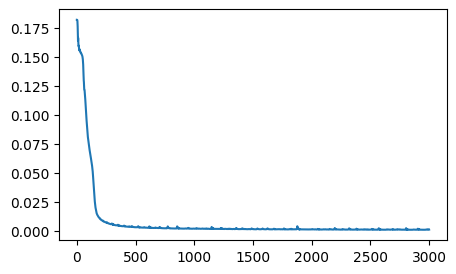

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(0,3000), loss_list)

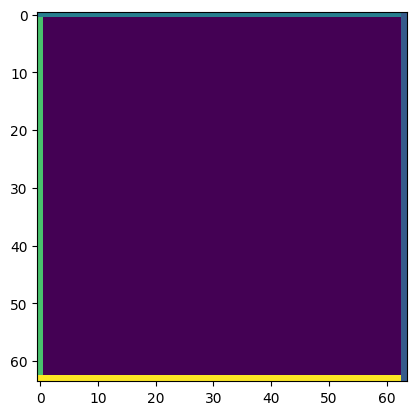

In [ ]:
test_input = np.zeros((64, 64))
test_input[:, 0] = 0.5
test_input[0, :] = 0.3
test_input[-1, :] = 0.7
test_input[:, -1] = 0.2
plt.imshow(test_input)
test_input = torch.from_numpy(test_input).to(device)

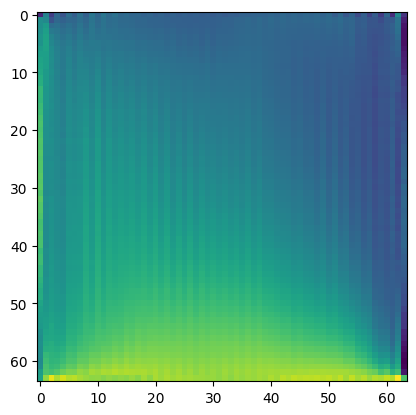

In [ ]:
test_output = FNO(test_input).cpu().detach().numpy()
plt.imshow(test_output)